# Lorenz: Reconstruction using delay coordinate embeddings

Reference: http://node99.org/tutorials/ar/

## Delay Coordinates Embedding
Often times one can only observe a single time series while the underlying dynamical system is composed of many variables. Is there a way to discover information about these unobserved variables? Takens theorem says that under certain conditions, a dynamical system can be reconstructed from a single time series. References:
 - http://www.scholarpedia.org/article/Attractor_reconstruction
 - https://www.youtube.com/watch?v=QQwtrWBwxQg
 - https://math.stackexchange.com/questions/3076299/why-lorenz-attractor-can-be-embedded-by-a-3-step-time-delay-map
 
### Summary:
 - Two hyperparameters: delay time, embedding dimension.
 - For Lorenz equations, Takens theorem gives the upper limit of 7 dimensions as the embedding dimension.
 - Appropriate delay time is usually guessed by the first minimum of the autocorrelation or the mutual information coefficient.

### TODO
 - Compute Lyapunov exponents.

In [ ]:
import numpy as np
from scipy.integrate import odeint
from scipy.linalg import svd
from minepy import MINE
from mpl_toolkits.mplot3d.axes3d import Axes3D

In [1]:
def lorentz_deriv(X, t0, sigma=10., beta=8./3, rho=28.0):
    """Compute the time-derivative of a Lorenz system."""
    return [sigma * (X[1] - X[0]), X[0] * (rho - X[2]) - X[1], X[0] * X[1] - beta * X[2]]

x0 = np.array([-8.0, 8.0, 27.0]) # Initial conditions
t = np.linspace(0, 100, 10000)  # dt = 0.01

# Solve
data = odeint(lorentz_deriv, x0, t)
x, y, z = data.T

/home/fnauman/anaconda3/envs/plotly/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


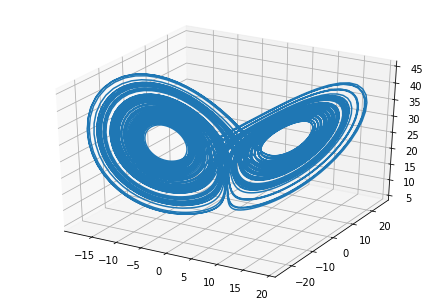

In [2]:
figure = plt.figure()
axes = Axes3D(figure)
#axes.plot3D(data[:,0], data[:,1], data[:,2])
axes.plot3D(x, y, z)
figure.add_axes(axes)

Text(0, 0.5, 'z')

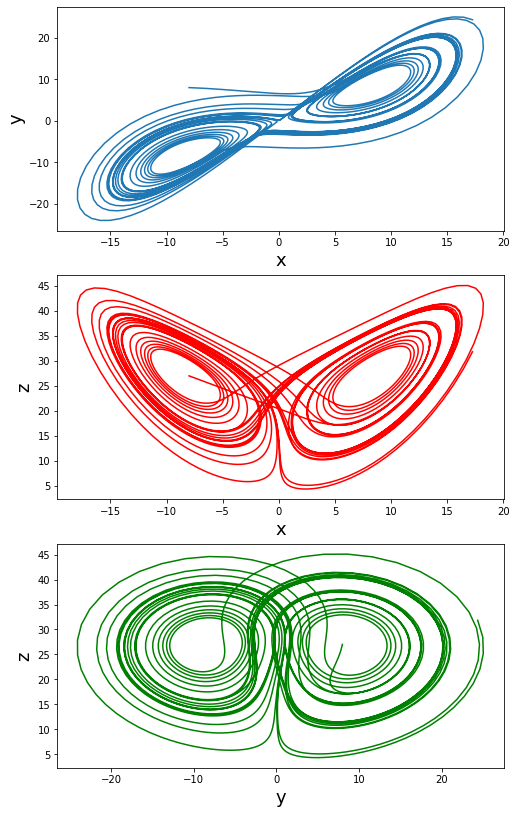

In [3]:
ind = 3000

fig, axs = plt.subplots(3, 1, figsize=(8,14))

axs[0].plot(x[:ind], y[:ind])
#axs[0].set_title("x vs y", fontsize=18)
axs[0].set_xlabel("x", fontsize=18)
axs[0].set_ylabel("y", fontsize=18)

axs[1].plot(x[:ind], z[:ind], 'r')
#axs[1].set_title("x vs z", fontsize=18)
axs[1].set_xlabel("x", fontsize=18)
axs[1].set_ylabel("z", fontsize=18)

axs[2].plot(y[:ind], z[:ind], 'g')
#axs[2].set_title("y vs z", fontsize=18)
axs[2].set_xlabel("y", fontsize=18)
axs[2].set_ylabel("z", fontsize=18)

Text(0.5, 0, 'Time')

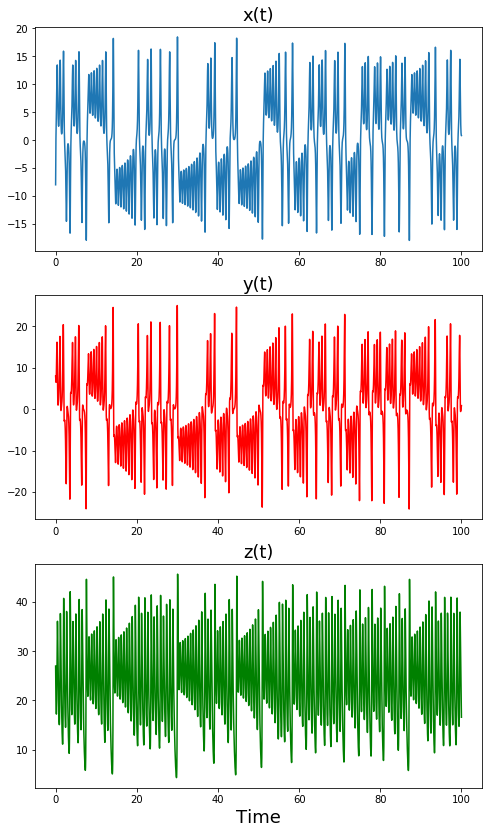

In [4]:
fig, axs = plt.subplots(3, 1, figsize=(8,14))

axs[0].plot(t, x)
axs[0].set_title("x(t)", fontsize=18)

axs[1].plot(t, y, 'r')
axs[1].set_title("y(t)", fontsize=18)

axs[2].plot(t, z, 'g')
axs[2].set_title("z(t)", fontsize=18)
axs[2].set_xlabel("Time", fontsize=18)

Text(0.5, 0, 'Time')

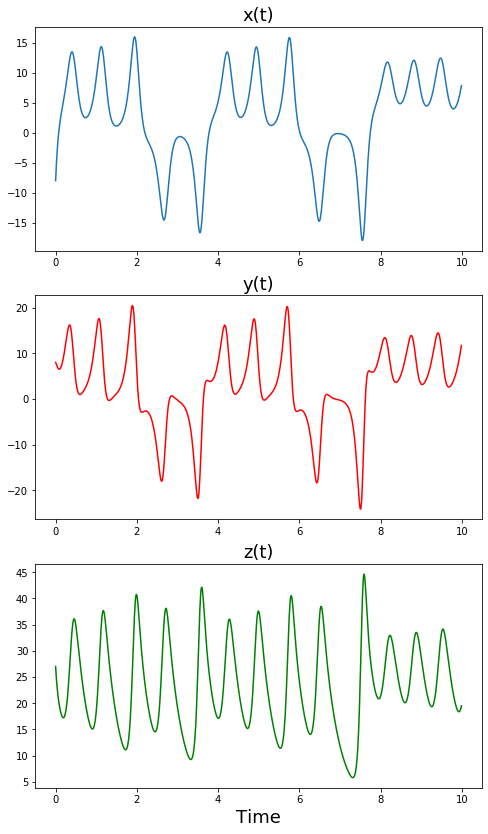

In [5]:
fig, axs = plt.subplots(3, 1, figsize=(8,14))

axs[0].plot(t[:1000], x[:1000])
axs[0].set_title("x(t)", fontsize=18)

axs[1].plot(t[:1000], y[:1000], 'r')
axs[1].set_title("y(t)", fontsize=18)

axs[2].plot(t[:1000], z[:1000], 'g')
axs[2].set_title("z(t)", fontsize=18)
axs[2].set_xlabel("Time", fontsize=18)

## Method 1: SVD of the Hankel matrix to reconstruct the dynamical system

Brunton et al. 2016 suggest using the the first few singular modes of the Hankel matrix of the original series to do the reconstruction. [Paper](https://www.pnas.org/content/113/15/3932) supplementary information section 4.5. I will be repeating the analysis below.

### Create Hankel matrix

In [6]:
def create_hankel(array, nrows=None, delay=None, nozeros=True):
  """ Creates a Hankel matrix with specified delay and number of rows"""

  """
  nrows: 
    If specified, only array elements up to nrows will be used. This is
    different from default Hankel matrix behavior that uses the WHOLE matrix
  nozeros:
    By default, Hankel matrix has zeros in the lower triangle
  delay:
    By default, Hankel shifts (delays) every column by 1 only
  """
  
  from scipy.linalg import hankel
  
  array = array[::delay] if delay else array

  if len(list(array.shape)) > 1:
    raise ValueError("This function only works for 1D arrays")

  if (nrows is not None) and (nrows > array.size): 
    import warnings
    warnings.warn("Specifying nrows>array.size will set the nrows=array.size")
  
  if nozeros:
    try:
      hank = hankel(c=array[:nrows], r=array[nrows-1:])
    except:
      raise ValueError("nrows set to None (default). "
                       "Cannot use nozeros=True with nrows=None.")
  else:
    hank = hankel(c=array[:nrows])

  return hank

In [7]:
x_hank = create_hankel(x, nrows=10)
#x_hank[0, :], x_hank[:, 0]

(array([-8.        , -6.48626016, -5.13776363, ...,  1.433487  ,
         1.30032198,  1.1876529 ]),
 array([-8.        , -6.48626016, -5.13776363, -3.94116852, -2.88164972,
        -1.943939  , -1.11302206, -0.37457745,  0.28477019,  0.87732613]))

In [9]:
x_hank.shape

(10, 9991)

### Compute SVD

In [11]:
U, Sig, Vh = svd(x_hank[:,:-1], False)

In [12]:
U.shape, Sig.shape, Vh.shape

((10, 10), (10,), (10, 9990))

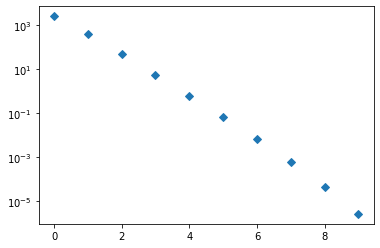

In [13]:
plt.semilogy(Sig[:10], 'D')

In [14]:
x_new, y_new, z_new = Vh[:3]

/home/fnauman/anaconda3/envs/plotly/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


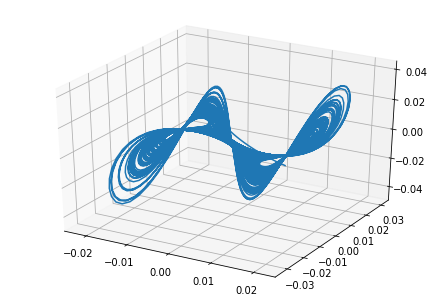

In [15]:
figure = plt.figure()
axes = Axes3D(figure)
axes.plot3D(x_new, y_new, z_new)
figure.add_axes(axes)

In [16]:
ind = 300
t_new = t[:ind]

Text(0, 0.5, 'z')

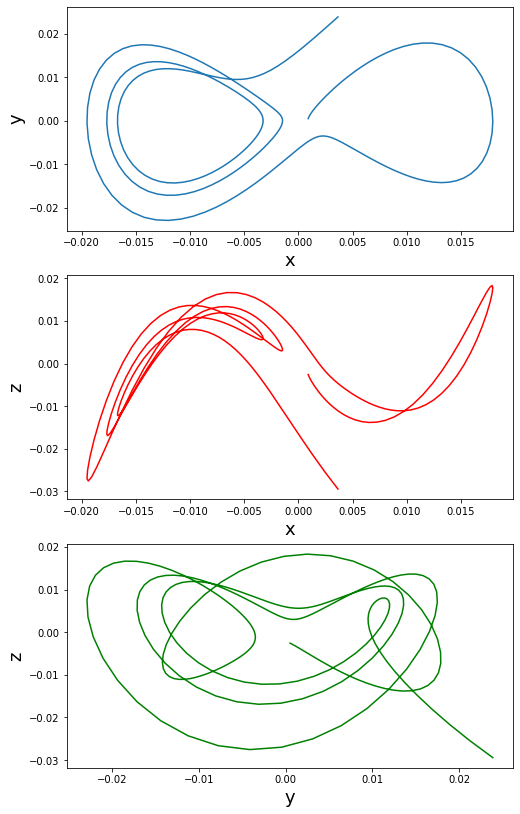

In [17]:
fig, axs = plt.subplots(3, 1, figsize=(8,14))

axs[0].plot(x_new[:ind], y_new[:ind])
#axs[0].set_title("x vs y", fontsize=18)
axs[0].set_xlabel("x", fontsize=18)
axs[0].set_ylabel("y", fontsize=18)

axs[1].plot(x_new[:ind], z_new[:ind], 'r')
#axs[1].set_title("x vs z", fontsize=18)
axs[1].set_xlabel("x", fontsize=18)
axs[1].set_ylabel("z", fontsize=18)

axs[2].plot(y_new[:ind], z_new[:ind], 'g')
#axs[2].set_title("y vs z", fontsize=18)
axs[2].set_xlabel("y", fontsize=18)
axs[2].set_ylabel("z", fontsize=18)

Text(0.5, 0, 'Time')

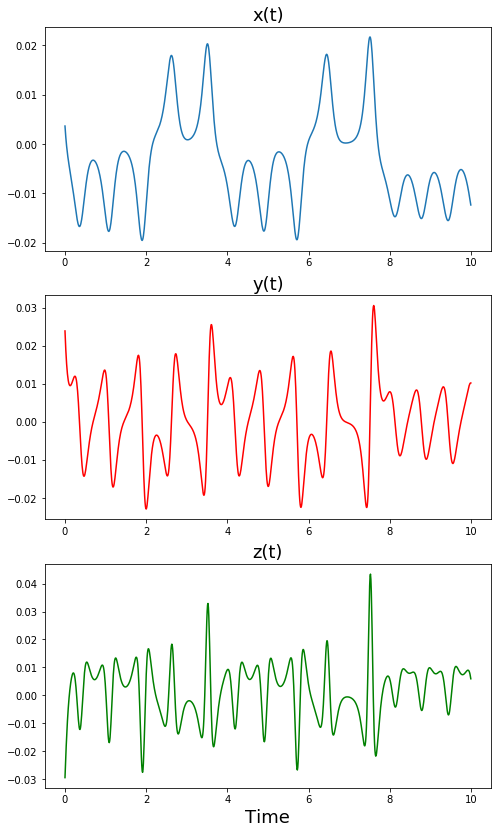

In [18]:
fig, axs = plt.subplots(3, 1, figsize=(8,14))

axs[0].plot(t[:1000], x_new[:1000])
axs[0].set_title("x(t)", fontsize=18)

axs[1].plot(t[:1000], y_new[:1000], 'r')
axs[1].set_title("y(t)", fontsize=18)

axs[2].plot(t[:1000], z_new[:1000], 'g')
axs[2].set_title("z(t)", fontsize=18)
axs[2].set_xlabel("Time", fontsize=18)

## Method 2: Guess optimal delay embedding time using either mutual Information or autocorrelation

In [32]:
tau_max = 100

mis = []
corr = []

mine_ = MINE()
for tau in range(1, tau_max):

    # Correlation
    corr_ = np.corrcoef(np.array([x[:-tau], x[tau:]]))
    corr.append(corr_[0,1])

    # Mutual Information
    unlagged = x[:-tau]
    lagged   = np.roll(x, -tau)[:-tau]
    joint    = np.hstack((unlagged, lagged))
    mine_.compute_score(unlagged, lagged)
    m = mine_.mic()
    mis.append(m)
    
    print(f"Lag = {tau}:  Correlation = {corr_[0,1]: .3f}, Mutual Information = {m: .3f}")

Lag = 1:  Correlation =  0.999, Mutual Information =  1.000
Lag = 2:  Correlation =  0.994, Mutual Information =  0.994
Lag = 3:  Correlation =  0.987, Mutual Information =  0.977
Lag = 4:  Correlation =  0.978, Mutual Information =  0.959
Lag = 5:  Correlation =  0.966, Mutual Information =  0.942
Lag = 6:  Correlation =  0.951, Mutual Information =  0.924
Lag = 7:  Correlation =  0.935, Mutual Information =  0.905
Lag = 8:  Correlation =  0.916, Mutual Information =  0.890
Lag = 9:  Correlation =  0.896, Mutual Information =  0.873
Lag = 10:  Correlation =  0.874, Mutual Information =  0.857
Lag = 11:  Correlation =  0.851, Mutual Information =  0.842
Lag = 12:  Correlation =  0.826, Mutual Information =  0.825
Lag = 13:  Correlation =  0.801, Mutual Information =  0.811
Lag = 14:  Correlation =  0.775, Mutual Information =  0.795
Lag = 15:  Correlation =  0.749, Mutual Information =  0.780
Lag = 16:  Correlation =  0.723, Mutual Information =  0.764
Lag = 17:  Correlation =  0.696, 

In [33]:
mis_np = np.array(mis)
mis_np.shape

(99,)

In [34]:
corr_np = np.array(corr)
corr_np.shape

(99,)

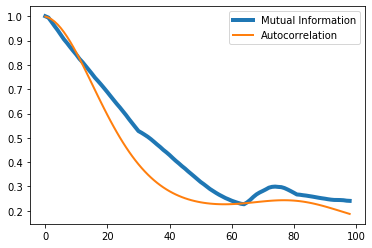

In [35]:
plt.plot(mis_np,  lw=4, label='Mutual Information')
plt.plot(corr_np, lw=2, label='Autocorrelation')
plt.legend()

/home/fnauman/anaconda3/envs/plotly/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


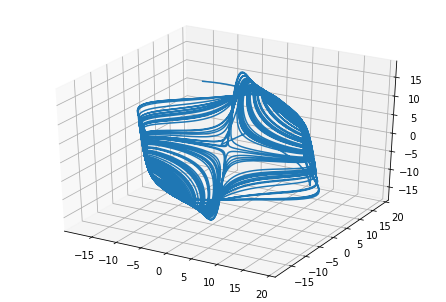

In [40]:
tau = 20

# plot time delay embedding
figure = plt.figure()
axes = Axes3D(figure)

data_lag0 = x[:-2].flatten()
data_lag1 = np.roll(x, -tau)[:-2].flatten()
data_lag2 = np.roll(x, -2 * tau)[:-2].flatten()
axes.plot3D(data_lag0, data_lag1, data_lag2)
figure.add_axes(axes)